In [2]:
# Step 1: 安裝所需的庫


# Step 2: 導入所需的庫
import numpy as np
import pandas as pd
import lime
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lime.lime_tabular import LimeTabularExplainer
from joblib import Parallel, delayed

from sklearn.metrics import r2_score
from scipy.optimize import minimize
from tqdm import tqdm  

In [167]:
CH_TO = pd.read_csv("C:/Users/fabia/Local_Work/FST/Data/測試資料/CH_TO.csv")
feature = CH_TO.drop(columns=["Y","Context Name"])#.to_numpy()
target = CH_TO["Y"]#.to_numpy()
#加入CROSS項目，有時候會顯著，有時候不會顯著，明顯受到切資料的影響， 但CROSS BEST的模型確實會比較好


# feature = pd.read_csv("C:/Users/fabia/Local_Work/FST/Data/測試資料/wb/Indicator_Data(1).csv").drop(columns=["Unnamed: 74","Context Name"])#.to_numpy()
# target = pd.read_csv("C:/Users/fabia/Local_Work/FST/Data/測試資料/wb/Metrology_Data(1).csv")["Point1"]#.to_numpy()

# data = pd.read_excel("C:/Users/fabia/Local_Work/FST/Data/測試資料/Array7_N808測試資料集/Model_TJN808XK_SAMP75.xlsx").drop(columns=["CONTEXTID"])
# feature = data.drop(columns=list(filter(lambda x: "T2_CD" in x,data.columns)))#.to_numpy()
# target = data["T2_CD01_Mean"]#.to_numpy()


columns_name = list(feature.columns) # or np.arange(0,feature.shape[1])

#
# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3)

# 訓練隨機森林回歸模型
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))


0.5589520354004185

In [168]:
y_test = pd.DataFrame(y_test)
# y_test.columns = ["target"]
origin_result= pd.concat([y_test,X_test],axis=1)
origin_result.columns = ["target"] + list(origin_result.columns[1:])

In [169]:
origin_result

,target,CH,Part,RTM_BACKSIDE_HE_FLOW_Step=07_Filter0_Mean,RTM_BACKSIDE_HE_PRESS_Step=07_Filter0_Mean,RTM_BIAS_RF_VOLTAGE_PROBE_Step=07_Filter0_Mean,RTM_BTM_RF_FWD_PFT_Step=07_Filter0_Mean,RTM_BTM_RF_FWD_PWR_Step=07_Filter0_Mean,RTM_CH_BTM_TEMP_Step=07_Filter0_Mean,RTM_CH_PRESS_Step=07_Filter0_Mean,...,RTM_GAS3_HBR(300)_Step=09_Filter0_Mean,RTM_GAS6_SF6_Step=09_Filter0_Mean,RTM_PROCHM_PRE_VLV_Step=09_Filter0_Mean,RTM_TIME_Step=09_Filter0_Mean,RTM_TOP_RF_FWD_PWR_Step=09_Filter0_Mean,RTM_TOP_RF_RFT_PWR_Step=09_Filter0_Mean,RTM_BTM_RF_FWD_PFT_Step=12_Filter0_Mean,RTM_PROCHM_PRE_VLV_Step=12_Filter0_Mean,RTM_TOP_RF_FWD_PWR_Step=12_Filter0_Mean,RTM_TOP_RF_RFT_PWR_Step=12_Filter0_Mean
39,14349.0,3,8177,3.173828,14.96582,107.22660,0.000000,39.84375,50.6,4.248047,...,174.9847,15.99731,99.62497,180.52,997.9297,1.152344,1.171875,114.7335,249.4824,0.000000
171,13951.4,3,8996,1.464844,14.96582,101.36720,0.000000,39.84375,50.7,4.150391,...,174.9390,15.99884,99.62497,175.51,998.0264,1.702148,1.171875,116.0193,249.6484,0.567383
400,14122.4,3,8997,1.464844,14.96582,100.19530,0.000000,39.25781,50.8,4.150391,...,175.0031,15.99884,99.62497,177.86,998.0264,1.702148,1.171875,116.3407,249.0811,0.567383
477,14674.8,3,8997,1.464844,14.96582,103.71090,0.000000,39.84375,50.6,4.150391,...,174.9664,15.99884,101.23230,179.53,997.4590,1.702148,1.171875,116.3407,249.0811,0.567383
73,14087.0,2,8177,1.269531,14.96582,108.98440,-0.566406,39.08203,50.8,4.150391,...,174.9481,15.99884,106.05410,179.55,998.3276,0.000000,1.132813,122.7699,248.5864,-0.568848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,14027.4,2,8177,1.171875,14.96582,113.67190,-0.566406,39.64844,51.1,4.150391,...,174.9939,15.99976,94.80310,184.73,997.1899,0.568848,1.132813,111.5189,248.5864,-0.568848
14,13749.8,3,8996,3.027344,14.96582,103.12500,0.000000,39.84375,50.5,4.150391,...,174.9847,15.99731,102.83950,177.05,997.9297,1.152344,1.171875,117.9480,248.9063,0.576172
261,13924.8,2,8177,1.318359,14.96582,113.67190,-0.566406,39.08203,51.2,4.199219,...,175.0031,15.99884,94.80310,180.01,997.1899,0.568848,1.132813,111.5189,248.5864,-0.568848
192,14048.4,2,8997,1.171875,14.96582,114.84380,-0.566406,39.08203,51.2,4.150391,...,174.9573,15.99884,91.90999,179.03,997.1899,0.000000,1.132813,109.2687,248.5864,-0.568848


In [170]:

def local_calculation(explainer,model,feature,instance_index):
    local_feature_values = feature[instance_index,:]
    exp = explainer.explain_instance(data_row=local_feature_values, predict_fn=model.predict,num_features=feature.shape[1])
    local_feature_importances = np.array([weight for feature, weight in exp.as_list()])
    intercept = exp.intercept[0]

    local_result = np.append(local_feature_importances, intercept).reshape(-1,1)
    return local_result # [,-1] = intercept


def lime_calculation(feature,feature_names,model,mode,n_jobs): # ='regression' or classification
    if isinstance(feature,pd.Series):
        feature = feature.to_numpy()
    if isinstance(feature,pd.DataFrame):
        feature = feature.to_numpy()
    isinstance_num, feature_num= feature.shape[0],feature.shape[1]
    
    explainer = lime.lime_tabular.LimeTabularExplainer(training_data=feature, feature_names=feature_names,
                                                       verbose=False, 
                                                       mode=mode)

    lime_result = Parallel(n_jobs=n_jobs,prefer='threads',backend='loky')(delayed(local_calculation)(explainer=explainer,
                                                                                                     model=model,
                                                                                                     feature=feature,
                                                                                                     instance_index=i) for i in tqdm(range(isinstance_num)))
    lime_result =np.column_stack(lime_result)

    lime_importances = lime_result[:-1,:] 
    lime_intercept = lime_result[-1,:]
    # lime_importances : (feature_number, instance_number)
    # lime_intercept : (feature_number,)
    return feature, lime_importances, lime_intercept

In [193]:
def optimization(y,X,W,B,method):
    # X : (1, feature_number)
    # W : (feature_number, instance_number)
    # B : (feature_number,)

    X_num = X.shape[1]
    a_num = X.shape[0]
    # for mean,std_dev in zip(X.mean(axis=0),X.std(axis=0)):
    #     guess = np.random.normal(mean, 3*std_dev, 1)
    #     X_guess.append(guess)

    col_mean = np.nanmean(X, axis=0)
    #Find indices that you need to replace
    inds = np.where(np.isnan(X))
    #Place column means in the indices. Align the arrays using take
    X[inds] = np.take(col_mean, inds[1])
    X_guess = []
    for mx in np.max(X,axis=0):
        X_guess.append(np.array([mx]))

    a_guess = []
    for _ in range(X.shape[0]):
        guess = np.random.uniform(0.1, 2.0, 1) # 是否恆大於 1 ? y_lime 和 y_pred之間的關係 # 會介於 0 ~ inf # 取決於模型好壞
        a_guess.append(guess)
    # GPT說法
    # R2 = 0.8， a = 0.9~1.1
    # R2 = 0.1, a= 0.1~10
    initial_guess = np.concatenate(X_guess+a_guess) # 這邊很重要，會影響X和a的shape # 也會影響往後的估計，所以要曲多少呢?
    def objective(params):
        #loss = np.inf
        #for i in range(10):
        x = params[:X_num].reshape(1, X_num)
        a = params[X_num:].reshape(1,a_num)
        #A = np.tile(a.reshape(-1, 1), W.shape[1])
        #Y_pred = a * (np.dot(X, W) + B)
        #Y_pred = np.median(np.dot(X, W)*a+ B) # Y_pred 是個array
        print("HERE")
        y_pred = np.dot(x, W)*a + B
        print("HERE 2")
        y_pred = y_pred.reshape(-1,1)
        # array的數值通通減去 單一數值，相減後要越小越好

        y_true = np.array([y])
        loss = np.square(y_pred - y_true).sum() # 要如何定義好的LOSS呢?
        

        # if loss_ < loss:
        #     loss = loss_
        #     params = params
        #     print(i,loss,params)
        return loss

    result = minimize(objective, initial_guess, method=method)# 'L-BFGS-B':還可以?速度也很快,'Nelder-Mead':太久，有點太大, trust-constr, 'TNC'
    # 最佳解
    optimal_x = result.x[:X_num]
    return optimal_x

In [194]:
def feature_simulation(y,X,W,B,optimize_method,feature_name,iteration,n_jobs):
    # expected_y  # 透過這個值，逆推合適的X # 示例數值 # real, 這個之後是重要INPUT，已知
    # X 和 lime的

    # Y,W,B,feature,iteration,method
    optimal_x_list = Parallel(n_jobs=n_jobs,prefer='threads',backend='loky')(delayed(optimization)(y,X,W,B,optimize_method) for _ in range(iteration))
    #best_loss = objective(result.x)
    optimal_result = pd.DataFrame(np.row_stack(optimal_x_list))
    optimal_result.columns = feature_name
    # 這個之後有需要拿掉嗎?單純實驗需要
    optimal_result["target"] = y
    #optimal_result["iteration"] = np.arange(0,iteration)
    # 註解吊飾因為節省空間
    optimal_result = optimal_result.set_index("target")
    return optimal_result

In [195]:
def simulation(y_array,lime_feature,lime_importances,lime_intercept,optimize_method,feature_name,iteration,n_jobs):
    if isinstance(y_array,pd.Series):
        y_array = y_array.to_numpy()
    if isinstance(y_array,list):
        y_array = np.array(y_array)
    if isinstance(y_array,int) or isinstance(y_array,float):
        y_array = np.array([y_array])
    if isinstance(y_array,pd.DataFrame):
        y_array = target.to_numpy().ravel()
    result = Parallel(n_jobs=n_jobs,prefer='threads',backend='loky')(delayed(feature_simulation)(y=y,
                                                                                                 X=lime_feature,
                                                                                                 W=lime_importances,
                                                                                                 B=lime_intercept,
                                                                                                 optimize_method=optimize_method,
                                                                                                 feature_name=feature_name,
                                                                                                 iteration=iteration,
                                                                                                 n_jobs=n_jobs) for y in tqdm(y_array))

    result = pd.concat(result,axis=0)
    
    return result
# 這裡要寫隊要為度的筆記 dot(lime_feature[1:5,:],lime_importances[:,1:5]) # 很重要，因為lime_importances剛開始設計時， 內是為feature_weight, local_sample
# 基本上全部都要取出
# 這樣估計才准

In [174]:
y_test.shape

(191, 1)

In [196]:


lime_feature, lime_importances, lime_intercept = lime_calculation(feature=X_test,feature_names=columns_name,model=reg,mode="regression",n_jobs=-1)








  0%|          | 0/191 [00:00<?, ?it/s]



































































100%|██████████| 191/191 [00:07<00:00, 26.85it/s]


In [185]:
xxxx= feature_simulation(y=y_test.to_numpy()[0,0],X=lime_feature,W=lime_importances,B=lime_intercept,optimize_method='L-BFGS-B',feature_name=columns_name,iteration=2,n_jobs=-1)

array([14349. , 13951.4, 14122.4])

In [205]:
simulation_result = simulation(y_array= y_test,# (instance_num,)
                          lime_feature=lime_feature, # (instance_num, feature_num)
                          lime_importances=lime_importances, # (feature_num, instance_num)
                          lime_intercept=lime_intercept,# (instance_num,)
                          feature_name = columns_name,
                          iteration=2, 
                          optimize_method='L-BFGS-B',
                          n_jobs=-1)

KeyboardInterrupt: 

In [202]:
simulation_result

,CH,Part,RTM_BACKSIDE_HE_FLOW_Step=07_Filter0_Mean,RTM_BACKSIDE_HE_PRESS_Step=07_Filter0_Mean,RTM_BIAS_RF_VOLTAGE_PROBE_Step=07_Filter0_Mean,RTM_BTM_RF_FWD_PFT_Step=07_Filter0_Mean,RTM_BTM_RF_FWD_PWR_Step=07_Filter0_Mean,RTM_CH_BTM_TEMP_Step=07_Filter0_Mean,RTM_CH_PRESS_Step=07_Filter0_Mean,RTM_PROCHM_PRE_VLV_Step=07_Filter0_Mean,...,RTM_GAS3_HBR(300)_Step=09_Filter0_Mean,RTM_GAS6_SF6_Step=09_Filter0_Mean,RTM_PROCHM_PRE_VLV_Step=09_Filter0_Mean,RTM_TIME_Step=09_Filter0_Mean,RTM_TOP_RF_FWD_PWR_Step=09_Filter0_Mean,RTM_TOP_RF_RFT_PWR_Step=09_Filter0_Mean,RTM_BTM_RF_FWD_PFT_Step=12_Filter0_Mean,RTM_PROCHM_PRE_VLV_Step=12_Filter0_Mean,RTM_TOP_RF_FWD_PWR_Step=12_Filter0_Mean,RTM_TOP_RF_RFT_PWR_Step=12_Filter0_Mean
target,,,,,,,,,,,,,,,,,,,,,
14349.0,3.996820,9115.985478,3.808878,14.991075,115.429680,0.585701,40.214942,51.299708,4.248558,185.775679,...,175.067007,16.000592,107.339813,184.860011,999.465362,2.269584,1.171810,126.627394,249.724074,0.576181
14349.0,4.000740,9115.984710,3.806748,14.992113,115.430416,0.584909,40.215306,51.299645,4.247956,185.775495,...,175.067223,16.000509,107.339918,184.859948,999.465382,2.269554,1.171824,126.627383,249.724103,0.576169
13951.4,4.000869,9115.983378,3.808080,14.991582,115.431502,0.585241,40.215000,51.299553,4.248086,185.775689,...,175.067164,16.000540,107.339894,184.860021,999.465356,2.269596,1.171827,126.627382,249.724069,0.576177
13951.4,3.999113,9115.985205,3.808953,14.991822,115.429964,0.585325,40.215470,51.299170,4.248293,185.775560,...,175.067116,16.000486,107.339919,184.860056,999.465320,2.269541,1.171858,126.627368,249.724092,0.576185
14122.4,3.998612,9115.984218,3.807838,14.992510,115.429650,0.585339,40.215771,51.299584,4.248041,185.775424,...,175.066948,16.000572,107.339915,184.859943,999.465322,2.269510,1.171845,126.627378,249.724084,0.576187
14122.4,4.001745,9115.982743,3.807928,14.991330,115.430082,0.585795,40.215123,51.300132,4.248174,185.775602,...,175.067002,16.000521,107.340020,184.860046,999.465295,2.269512,1.171813,126.627372,249.724077,0.576188


In [ ]:
# origin_values
#from scipy.stats import t,sem,norm
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
#import seaborn as sns
import scipy.stats


In [203]:

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def simulation_performance(simulation_result,origin_result,ci_level=95):
    result = pd.DataFrame(columns=['feature', 'origin_values', f'{ci_level}_ci_lower',f'{ci_level}_ci_upper',f'in_{ci_level}_interval',f'notin_{ci_level}_interval'])
    for y in set(simulation_result.index):
        for col in set(simulation_result.columns):
            
            simulated_value = simulation_result.loc[y,col]
            print(y,origin_result[origin_result["target"] == y])
            origin_values = origin_result[origin_result["target"] == y][col].values[0]
            _, ci_lower, ci_upper = mean_confidence_interval(simulated_value,ci_level*0.01)
            in_95_interval = ((origin_values >= ci_lower) & (origin_values <= ci_upper))
            notin_95_interval = ((origin_values < ci_lower) | (origin_values > ci_upper))
            result = result.append({
                'feature': col,
                'origin_values':origin_values,
                f'{ci_level}_ci_lower':ci_lower,
                f'{ci_level}_ci_upper':ci_upper,
                f'in_{ci_level}_interval': int(in_95_interval),
                f'notin_{ci_level}_interval': int(notin_95_interval)
            }, ignore_index=True)
    return result

In [ ]:

# def coverage_probability(true_array, simulation_array, confidence_level=0.95):
#     # 计算置信区间
#     lower_percentile = (1 - confidence_level) / 2 * 100
#     upper_percentile = (1 + confidence_level) / 2 * 100
    
#     lower_bounds = np.percentile(simulation_array, lower_percentile, axis=0)
#     upper_bounds = np.percentile(simulation_array, upper_percentile, axis=0)
    
#     # 检查真实值是否在置信区间内
#     coverage = (true_array >= lower_bounds) & (true_array <= upper_bounds)
    
#     # 计算覆盖概率
#     coverage_probability = np.mean(coverage)
    
#     return coverage_probability

In [158]:
simulation_result

,TLCD0900-SBHPTEMP_X,TLCD0900-SBHPTEMP1_X,TLCD0900-SBHPTEMP2_X,TLCD0900-SBHPTEMP3_X,TLCD0900-SBCPTEMP_X,TLCD0900-SBHPHOTAIRTEMP_X,TLCD0900-SBCYCLETIME_X,TLCD0900-SBHPPRCTIME_X,TLCD0900-SBCPPRCTIME_X,TLCD0900-DVPRCTIME_X,...,LENS-Focus_M10|3,LENS-Focus_M02|4,LENS-Focus_M03|4,LENS-Focus_M04|4,LENS-Focus_M05|4,LENS-Focus_M06|4,LENS-Focus_M07|4,LENS-Focus_M08|4,LENS-Focus_M09|4,LENS-Focus_M10|4
target,,,,,,,,,,,,,,,,,,,,,
4.268411,110.200685,115.101618,106.201216,104.599519,22.798431,-0.000711,579.901202,177.398727,137.099658,9.300200,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
4.268411,110.202779,115.103534,106.202622,104.601868,22.797847,-0.000388,579.902043,177.398196,137.100703,9.299964,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
4.268411,110.195667,115.096697,106.197840,104.598409,22.800629,0.000895,579.899593,177.400627,137.101500,9.299210,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
4.268411,110.199059,115.100722,106.201429,104.601219,22.797951,-0.000749,579.900483,177.398921,137.099581,9.299352,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
4.268411,110.196127,115.098447,106.198708,104.598779,22.799738,-0.000586,579.899696,177.399045,137.100675,9.299615,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.107667,110.195383,115.096741,106.197426,104.598545,22.800326,0.000571,579.899737,177.399587,137.101721,9.299438,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
4.107667,110.197681,115.097219,106.196860,104.600403,22.800339,0.001264,579.899203,177.399528,137.102719,9.298604,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317
4.107667,110.205356,115.102972,106.202247,104.603701,22.797207,0.002241,579.902580,177.397897,137.102178,9.298177,...,11.185814,30.491438,32.220861,41.554505,22.885716,48.143605,31.647448,46.977699,43.997669,26.82317


In [204]:

result = simulation_performance(simulation_result,origin_result,ci_level=95)

14122.4       target  CH  Part  RTM_BACKSIDE_HE_FLOW_Step=07_Filter0_Mean  \
400  14122.4   3  8997                                   1.464844   

     RTM_BACKSIDE_HE_PRESS_Step=07_Filter0_Mean  \
400                                    14.96582   

     RTM_BIAS_RF_VOLTAGE_PROBE_Step=07_Filter0_Mean  \
400                                        100.1953   

     RTM_BTM_RF_FWD_PFT_Step=07_Filter0_Mean  \
400                                      0.0   

     RTM_BTM_RF_FWD_PWR_Step=07_Filter0_Mean  \
400                                 39.25781   

     RTM_CH_BTM_TEMP_Step=07_Filter0_Mean  RTM_CH_PRESS_Step=07_Filter0_Mean  \
400                                  50.8                           4.150391   

     ...  RTM_GAS3_HBR(300)_Step=09_Filter0_Mean  \
400  ...                                175.0031   

     RTM_GAS6_SF6_Step=09_Filter0_Mean  \
400                           15.99884   

     RTM_PROCHM_PRE_VLV_Step=09_Filter0_Mean  RTM_TIME_Step=09_Filter0_Mean  \
400            

NameError: name 'scipy' is not defined

In [153]:
len(set(simulation_result.index))

75

In [154]:
len(origin_result["target"]) #

23

In [76]:
result[result["feature"] =="LENS-Focus_M03|1"]

,feature,origin_values,95_ci_lower,95_ci_upper,in_95_interval,notin_95_interval
0,LENS-Focus_M03|1,17.500019,17.642945,19.433833,0,1
189,LENS-Focus_M03|1,NaN,16.693664,18.253432,0,0
378,LENS-Focus_M03|1,11.941017,16.832916,18.486231,0,1
567,LENS-Focus_M03|1,NaN,16.006629,17.795083,0,0
756,LENS-Focus_M03|1,NaN,15.945292,17.555531,0,0
945,LENS-Focus_M03|1,NaN,17.147976,18.994030,0,0
1134,LENS-Focus_M03|1,NaN,17.246389,19.048960,0,0
1323,LENS-Focus_M03|1,NaN,17.035296,18.708780,0,0
1512,LENS-Focus_M03|1,NaN,16.401913,18.258474,0,0
1701,LENS-Focus_M03|1,NaN,16.887877,18.665413,0,0


In [74]:
grouped_df

,feature,in_95_interval,notin_95_interval,total,in_95_interval_ratio,notin_95_interval_ratio
0,LENS-Focus_M02|1,2,4,6,2,4
1,LENS-Focus_M02|2,0,6,6,0,6
2,LENS-Focus_M02|3,1,5,6,1,5
3,LENS-Focus_M02|4,0,6,6,0,6
4,LENS-Focus_M03|1,2,4,6,2,4
...,...,...,...,...,...,...
184,TLCD0904-MSKPRE_SHFX_X,5,1,6,5,1
185,TLCD0904-MSKPRE_SHFY_X,4,2,6,4,2
186,TLCD0904-MSKROTCAL_R_X,1,5,6,1,5
187,TLCD0904-MSKROTCAL_X_X,5,1,6,5,1


In [70]:
import matplotlib.pyplot as plt

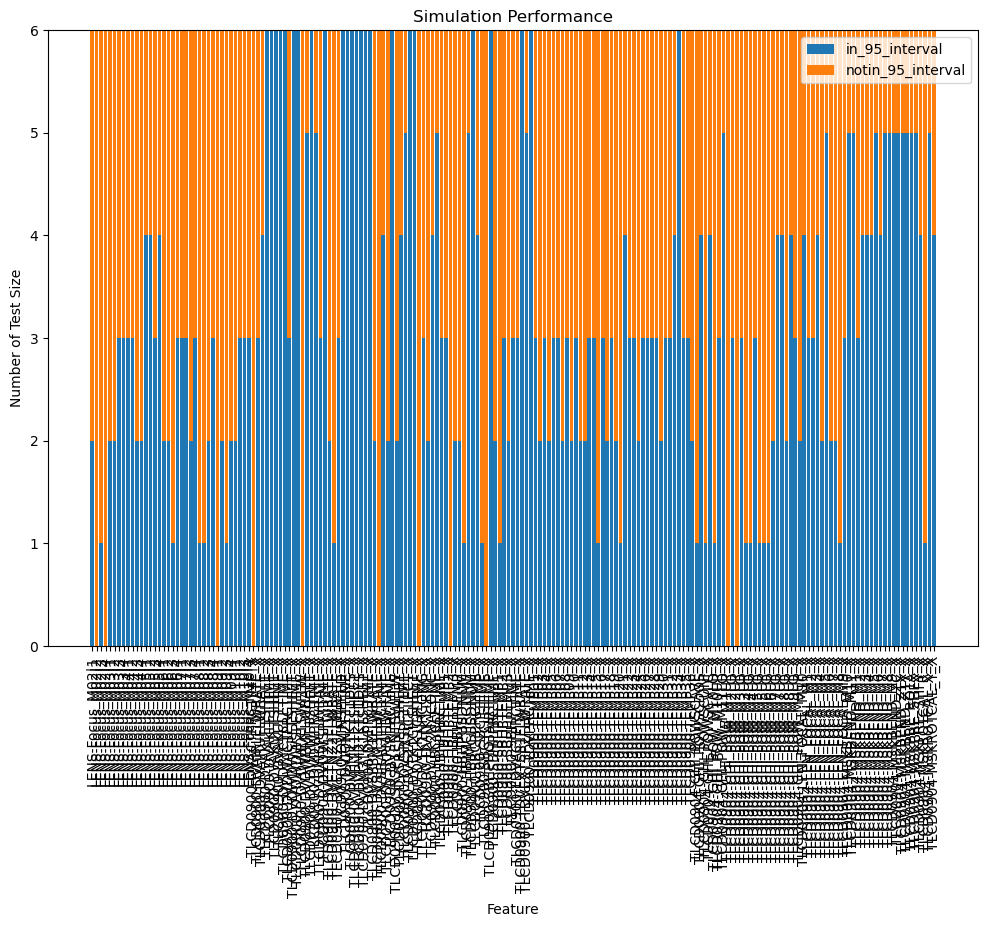

In [71]:
ci_level = 95# 1 sigma:68, 2 sigma:95, 3 sigma:99.7

df = result[["feature","in_95_interval",'notin_95_interval']]

# 按feature汇总in_95_interval和notin_95_interval的数量
grouped_df = df.groupby('feature').sum().reset_index()

# 计算比例
grouped_df['total'] = grouped_df['in_95_interval'] + grouped_df['notin_95_interval']
grouped_df['in_95_interval_ratio'] = grouped_df['in_95_interval'] #/ grouped_df['total']
grouped_df['notin_95_interval_ratio'] = grouped_df['notin_95_interval'] #/ grouped_df['total']

# 画堆叠柱状图
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(grouped_df['feature'], grouped_df['in_95_interval_ratio'], label='in_95_interval')
ax.bar(grouped_df['feature'], grouped_df['notin_95_interval_ratio'], bottom=grouped_df['in_95_interval_ratio'], label='notin_95_interval')

ax.set_xlabel('Feature')
ax.set_ylabel('Number of Test Size')
ax.set_title('Simulation Performance')
ax.legend()

plt.xticks(rotation=90)
plt.show()

In [ ]:


# 计算 95% 置信区间




In [42]:
#simulation_result=pd.read_excel("C:/Users/fabia/Local_Work/FStech/wb_simulation.xlsx")


In [43]:
#simulation_result.to_csv("C:/Users/fabia/Local_Work/FStech/wb_simulation.xlsx",header=True, index=True,sep="\t")

In [45]:
feature
origin_result = feature.assign(process="origin")
simulation_result = simulation_result.assign(process="simulation")
custom_order = simulation_result.columns ################################### X_merge
origin_result = origin_result[list(custom_order)]
results = pd.concat([origin_result,simulation_result],axis=0)
results = pd.melt(results, id_vars=['process'], value_vars=custom_order) # 

In [46]:
results.to_csv("C:/Users/fabia/Local_Work/FStech/results_simulation_3.txt",header=True, index=True,sep="\t")


In [ ]:
###### 畫圖和信賴區間可能有錯 @@@@@@@@@@

,X_CENTER_DIST__Filter0_Mean,X_EDGE_DIST__Filter0_Mean,X_NOTCH_NOTCH_ANGEL_STEP=1_Filter0_Mean__Filter0_Mean,X_NOTCH_RADIAN_STEP=1_Filter0_Mean__Filter0_Mean,X_ORI_X__Filter0_Mean,X_ORI_Y__Filter0_Mean,X_P1_ACCUMULATION_CHAMBER_STEP=1_Filter0_Counter__Filter0_Mean,X_P1_ACCUMULATION_CHAMBER_STEP=1_Filter0_Mean__Filter0_Mean,X_P1_ANGLE_TV_STEP=1_Filter0_Mean__Filter0_Mean,X_P1_ANGLE_TV_STEP=1_Filter0_Std__Filter0_Mean,...,X_P4_PRESSURE_MANO_BS_STEP=1_Filter0_Range__Filter0_Mean,X_P4_TEMP_PED4_ACT_STEP=1_Filter0_Slope__Filter0_Mean,X_P4_TEMP_PED4_ACT_STEP=1_Filter0_Std__Filter0_Mean,X_P4_WF6_MFCK_STEP=1_Filter0_Accumulation__Filter0_Mean,X_P4_WF6_MFCK_STEP=1_Filter0_Slope__Filter0_Mean,X_P4_WF6_MFCK_STEP=1_Filter0_Std__Filter0_Mean,X_PREY__Filter0_Mean,X_ROTATE_X__Filter0_Mean,X_ROTATE_Y__Filter0_Mean,process
314,127192.920000,22807.080000,278.000000,4.852015,-116533.900000,50969.500000,86.000000,43087.000000,26.013924,0.193307,...,0.000000,-0.000423,0.073713,107.617182,0.019416,0.902463,62.920000,123209.923926,31580.918693,origin
568,101746.490000,48253.510000,225.000000,3.926991,-87505.630000,-51914.480000,86.000000,10863.000000,25.865823,0.124947,...,0.000000,0.003012,0.085700,102.050782,0.008271,1.181437,59.488000,36993.632094,94783.013773,origin
590,119617.540000,30382.460000,218.000000,3.804818,115692.000000,30392.710000,86.000000,27917.000000,25.739241,0.165187,...,0.000000,-0.000695,0.104861,58.679199,0.030104,0.862539,59.185000,-72454.919429,-95176.889715,origin
25,137236.440000,12763.560000,288.000000,5.026548,28607.290000,-134221.700000,86.000000,2067.000000,22.000000,0.000000,...,0.756840,-0.001212,0.108951,96.484370,0.022325,1.157960,68.986000,-105177.981994,88155.736601,origin
530,92611.220000,57388.780000,225.000000,3.926991,57635.520000,-72491.270000,86.000000,41141.000000,25.991139,0.165010,...,0.000000,-0.000552,0.122828,121.533196,0.016113,1.037356,57.865000,-90047.491786,21639.931028,origin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21895,46841.886393,-1128.202640,750.312390,6.410438,-23638.860479,-193761.124370,87.847388,-14183.639522,27.865738,0.474849,...,-0.251983,-0.007479,0.138310,118.821767,0.006890,2.455125,63.924195,138944.424912,-343932.105119,simulation
21896,288625.793250,-42991.389338,137.660811,4.803323,170146.528237,268257.646697,85.916550,-49671.764407,28.597780,0.138644,...,0.167761,0.001676,0.086958,74.901647,0.027978,1.174372,58.790377,-298172.655190,-62770.406194,simulation
21897,102824.167500,90378.845007,214.836011,7.908438,246637.398955,174418.684297,86.217007,52459.154926,23.308882,0.159782,...,0.140684,0.008245,0.316129,-7.595054,0.041263,0.466943,45.808573,17669.196434,188427.070534,simulation
21898,-21349.309290,127231.697668,262.200171,-0.151673,-109596.996841,-302219.389800,85.778492,-18453.170711,29.466197,0.353475,...,4.979568,0.000767,0.085893,85.305320,0.022677,1.774241,81.785267,195612.553121,-19499.759005,simulation


In [31]:
import pandas as pd
import scipy.stats as stats

# 假设数据存储在 'data.csv' 文件中
data = results

# 获取所有的 variables
variables = data['variable'].unique()

# 创建一个新的表格来存储结果
result = pd.DataFrame(columns=['variable', 'in_95_interval', 'notin_95_interval'])

# 遍历每个 variable
for var in variables:
    # 获取 simulation 过程中的值
    simulation_values = data[(data['variable'] == var) & (data['process'] == 'simulation')]['value']
    
    # 如果 simulation_values 为空，则跳过该 variable
    if simulation_values.empty:
        continue
    
    # 计算均值和标准差
    mean = simulation_values.mean()
    std = simulation_values.std()
    
    # 计算 95% 置信区间
    ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean, scale=std)
    
    # 获取 origin 过程中的值
    origin_values = data[(data['variable'] == var) & (data['process'] == 'origin')]['value']
    
    # 如果 origin_values 为空，则跳过该 variable
    if origin_values.empty:
        continue
    
    # 计算落在区间内和不在区间内的数量
    in_95_interval = ((origin_values >= ci_lower) & (origin_values <= ci_upper)).sum()
    notin_95_interval = ((origin_values < ci_lower) | (origin_values > ci_upper)).sum()
    
    # 将结果添加到新表格
    result = result.append({
        'variable': var,
        'in_95_interval': in_95_interval,
        'notin_95_interval': notin_95_interval
    }, ignore_index=True)


# 保存结果到文件
#result.to_csv('result.csv', index=False)


In [29]:
result

,variable,in_95_interval,notin_95_interval
0,TLCD0900-SBHPTEMP_X,15,0
1,TLCD0900-SBHPTEMP1_X,15,0
2,TLCD0900-SBHPTEMP2_X,15,0
3,TLCD0900-SBHPTEMP3_X,15,0
4,TLCD0900-SBCPTEMP_X,15,0
...,...,...,...
184,LENS-Focus_M06|4,15,0
185,LENS-Focus_M07|4,15,0
186,LENS-Focus_M08|4,15,0
187,LENS-Focus_M09|4,15,0


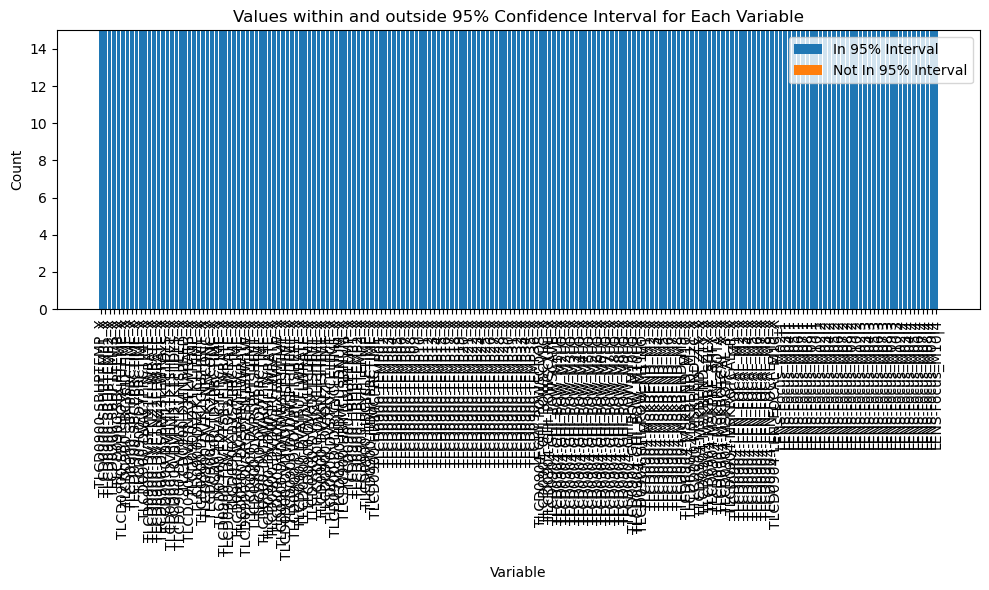

In [33]:
plt.figure(figsize=(10, 6))

# 生成堆叠条形图
plt.bar(result['variable'], result['in_95_interval'], label='In 95% Interval')
plt.bar(result['variable'], result['notin_95_interval'], bottom=result['in_95_interval'], label='Not In 95% Interval')

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Values within and outside 95% Confidence Interval for Each Variable')
plt.xlabel('Variable')
plt.ylabel('Count')

# 旋转X轴标签以防止重叠
plt.xticks(rotation=90)

# 显示图形
plt.tight_layout()
plt.show()

In [21]:

#Data['variable'] = pd.Categorical(Data['variable'], categories=custom_order, ordered=True)
#Data = Data.sort_values('variable')
#ata['value'] = pd.to_numeric(Data['value'])

,variable,process,value
300,TLCD0904-GHI_POW_M5UP_X,origin,"[430.61, 430.54, 430.98, 429.08, 434.47, 430.6..."
301,TLCD0904-GHI_POW_M5UP_X,simulation,"[429.00626110706366, 430.58703630505715, 427.7..."
302,TLCD0904-GHI_POW_M6LO_X,origin,"[428.19, 427.8, 428.09, 430.52, 435.88, 427.99..."
303,TLCD0904-GHI_POW_M6LO_X,simulation,"[436.59061204163174, 436.46532538481586, 425.2..."
304,TLCD0904-GHI_POW_M6UP_X,origin,"[431.43, 430.61, 431.48, 433.45, 439.02, 431.1..."
...,...,...,...
372,TLCD0904-MSKROTCAL_R_X,origin,"[-0.91, 0.22, -1.13, 0.38, -0.82, -0.75, -0.4,..."
373,TLCD0904-MSKROTCAL_R_X,simulation,"[-3.136807663376113, -2.1464990051669126, -1.5..."
374,TLCD0904-MSKROTCAL_X_X,origin,"[-17.89, -10.34, -17.5, -10.21, -9.83, -12.82,..."
375,TLCD0904-MSKROTCAL_X_X,simulation,"[-27.287436637154247, -0.3785613548931397, -21..."


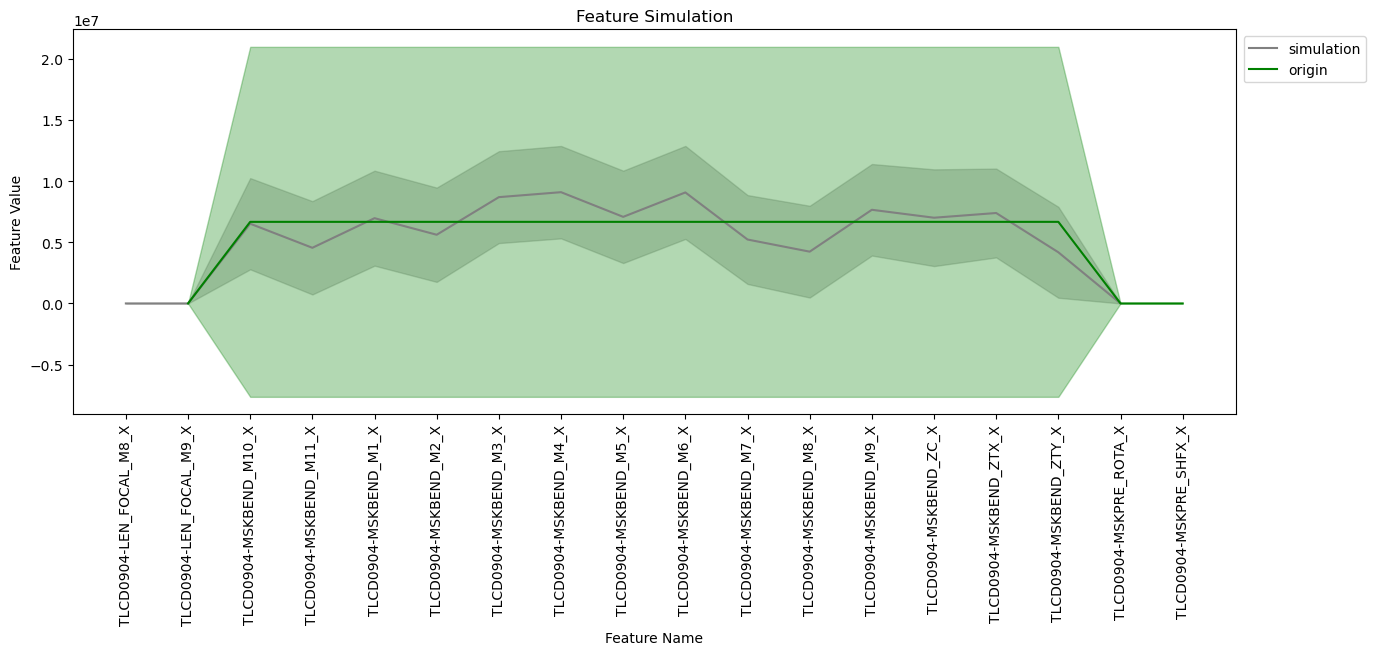

In [43]:
feature = X_test
origin_result = feature.assign(process="origin")
simulation_result = simulation_result.assign(process="simulation")
custom_order = simulation_result.columns ################################### X_merge
origin_result = origin_result[list(custom_order)]
results = pd.concat([origin_result,simulation_result],axis=0)
results = pd.melt(results, id_vars=['process'], value_vars=custom_order) # 


# 計算平均值和信賴區間
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# 分組計算
grouped = results.groupby(['variable', 'process'])['value'].apply(list).reset_index()
#grouped = grouped.iloc[335:369,:]
# 準備繪圖資料
plot_data = []
for _, row in grouped.iterrows():
    name = row['variable']
    type_ = row['process']
    values = row['value']
    mean, lower, upper = mean_confidence_interval(values)
    plot_data.append([name, type_, mean, lower, upper])

plot_df = pd.DataFrame(plot_data, columns=['variable', 'process', 'mean', 'lower', 'upper'])

# 繪圖
plt.figure(figsize=(15, 5))
for type_ in plot_df['process'].unique():
    type_data = plot_df[plot_df['process'] == type_]
    if type_ == 'simulation':
        plt.fill_between(type_data['variable'], type_data['lower'], type_data['upper'], color='gray', alpha=0.3)
        plt.plot(type_data['variable'], type_data['mean'], color='gray', label=f'{type_}')
    elif type_ == 'origin':
        plt.fill_between(type_data['variable'], type_data['lower'], type_data['upper'], color='green', alpha=0.3)
        plt.plot(type_data['variable'], type_data['mean'], color='green', label=f'{type_}')
    # elif type_ == 'prediction':
    #     plt.fill_between(type_data['variable'], type_data['lower'], type_data['upper'], color='green', alpha=0.3)
    #     plt.plot(type_data['variable'], type_data['mean'], color='green', label=f'{type_} mean')



plt.xlabel('Feature Name')
plt.ylabel('Feature Value')
plt.title('Feature Simulation')
plt.legend(bbox_to_anchor=(1.001, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

In [126]:
#np.array(list(custom_order) != 'process'])


array(['CH', 'Part', 'RTM_BACKSIDE_HE_FLOW_Step=07_Filter0_Mean',
       'RTM_BACKSIDE_HE_PRESS_Step=07_Filter0_Mean',
       'RTM_BIAS_RF_VOLTAGE_PROBE_Step=07_Filter0_Mean',
       'RTM_BTM_RF_FWD_PFT_Step=07_Filter0_Mean',
       'RTM_BTM_RF_FWD_PWR_Step=07_Filter0_Mean',
       'RTM_CH_BTM_TEMP_Step=07_Filter0_Mean',
       'RTM_CH_PRESS_Step=07_Filter0_Mean',
       'RTM_PROCHM_PRE_VLV_Step=07_Filter0_Mean',
       'RTM_TIME_Step=07_Filter0_Mean',
       'RTM_TOP_RF_FWD_PWR_Step=07_Filter0_Mean',
       'RTM_TOP_RF_RFT_PWR_Step=07_Filter0_Mean',
       'RTM_BACKSIDE_HE_FLOW_Step=09_Filter0_Mean',
       'RTM_BACKSIDE_HE_PRESS_Step=09_Filter0_Mean',
       'RTM_BIAS_RF_VOLTAGE_PROBE_Step=09_Filter0_Mean',
       'RTM_BTM_RF_FWD_PFT_Step=09_Filter0_Mean',
       'RTM_BTM_RF_FWD_PWR_Step=09_Filter0_Mean',
       'RTM_CH_BTM_TEMP_Step=09_Filter0_Mean',
       'RTM_CH_PRESS_Step=09_Filter0_Mean',
       'RTM_GAS3_HBR(300)_Step=09_Filter0_Mean',
       'RTM_GAS6_SF6_Step=09_Filter0_Mean

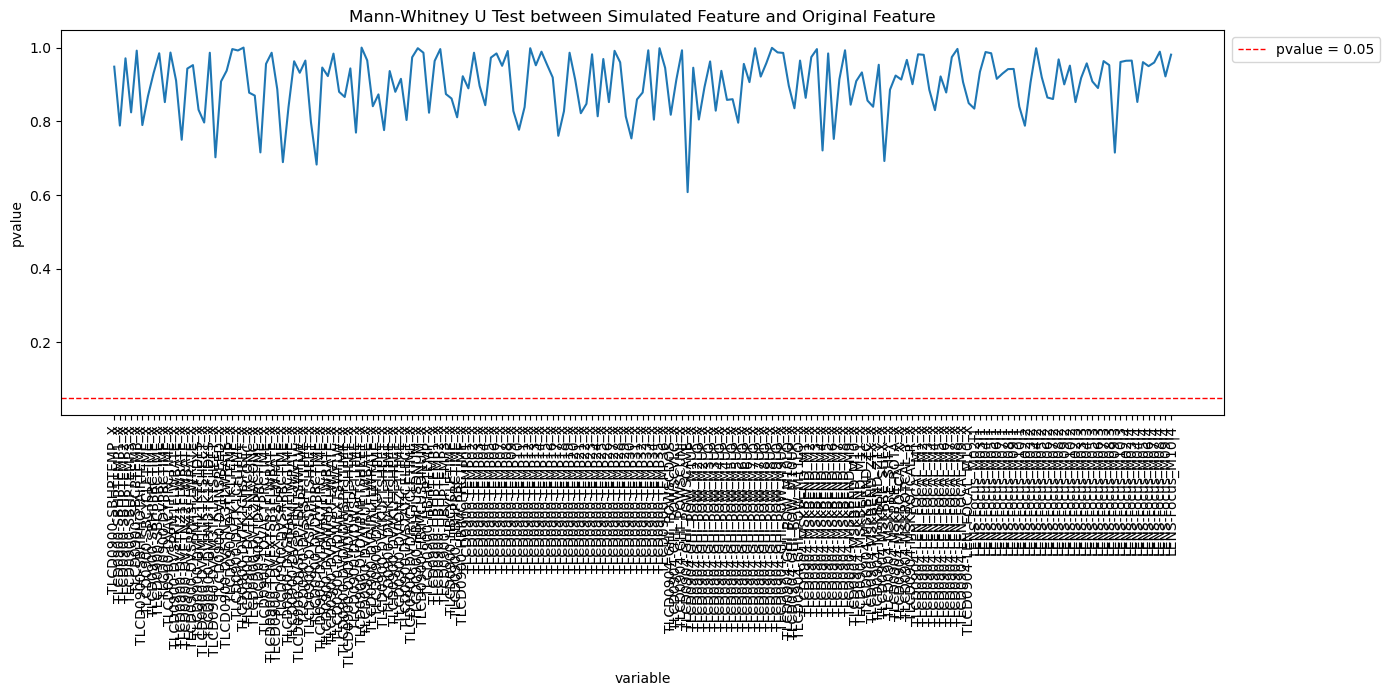

In [26]:
custom_order = np.array(list(custom_order))

r = []
feature_name = list(set(results.variable))
for i in feature_name:
    result = results[results.variable ==i]
    origin_value = np.array(result[result.process =="origin"].value)
    simulation_value = np.array(result[result.process =="simulation"].value)
    mwu= mannwhitneyu(origin_value,simulation_value).pvalue
    r.append([i,mwu])



data = pd.DataFrame(r).rename(columns={0:"variable",1:"pvalue"})
data['variable'] = pd.Categorical(data['variable'], categories=custom_order[custom_order != "process"], ordered=True)
data = data.sort_values('variable')
data['pvalue'] = pd.to_numeric(data['pvalue'])

plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x="variable", y="pvalue")
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='pvalue = 0.05')

# 添加圖例
#plt.legend()
plt.title('Mann-Whitney U Test between Simulated Feature and Original Feature')
plt.legend(bbox_to_anchor=(1.001, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()